### Solving for the WCS using catalogs

In this notebook we solve for a new WCS given an input catalog of x,y detections on an image and an assocaited reference catalog (Gaia). This uses the Rubin DM stack and AstrometryTask

In [1]:
#import lsst.utils.tests
import lsst.geom
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
from lsst.daf.persistence import Butler
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
from lsst.meas.astrom import AstrometryTask
from lsst.meas.astrom import plotAstrometry
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def makeSourceCat(bbox, distortedWcs, refObjLoader):
    """Make a source catalog (x, y positions) by reading the positions of reference stars from
    a reference catalog and a WCS 
    """
    
    #read data given bounds of WCS -> returns x,y and RA Dec
    loadRes = refObjLoader.loadPixelBox(bbox=bbox, wcs=distortedWcs, filterName="phot_rp_mean")
    refCat = loadRes.refCat

    # define keys for reference catalog
    refIdKey = refCat.schema["id"].asKey()
    refRAKey = refCat.schema["coord_ra"].asKey()
    refDecKey = refCat.schema["coord_dec"].asKey()
    refCentroidKey = afwTable.Point2DKey(refCat.schema["centroid"])
    refFluxRKey = refCat.schema["phot_rp_mean_flux"].asKey()

    #create source catalog skeleton
    sourceSchema = afwTable.SourceTable.makeMinimalSchema()
    measBase.SingleFrameMeasurementTask(schema=sourceSchema)  # expand the schema
    sourceCat = afwTable.SourceCatalog(sourceSchema)
    sourceCentroidKey = afwTable.Point2DKey(sourceSchema["slot_Centroid"])
    sourceIdKey = sourceSchema["id"].asKey()
    sourceRAKey = sourceSchema["coord_ra"].asKey()
    sourceDecKey = sourceSchema["coord_dec"].asKey()
    sourceInstFluxKey = sourceSchema["slot_ApFlux_instFlux"].asKey()
    sourceInstFluxErrKey = sourceSchema["slot_ApFlux_instFluxErr"].asKey()

    #populate source catalog with objects from reference catalog
    sourceCat.reserve(len(refCat))
    for refObj in refCat:
        src = sourceCat.addNew()
        src.set(sourceIdKey, refObj.get(refIdKey))
        src.set(sourceRAKey, refObj.get(refRAKey))
        src.set(sourceDecKey, refObj.get(refDecKey))
        src.set(sourceCentroidKey, refObj.get(refCentroidKey))
        src.set(sourceInstFluxKey, refObj.get(refFluxRKey))
        src.set(sourceInstFluxErrKey, refObj.get(refFluxRKey)/100)

    return sourceCat

In [3]:
def plotDistances(matches):
    '''Plot histogram of match separations'''
    distances = np.array([match.distance for match in results.matches])
    distances *= 180.*3600./np.pi
    plt.hist(distances)
    plt.xlabel("Distance (arcsecond)")
    plt.ylabel("Number")

In [4]:
#read in gaia data as a DM reference catalog using butler
refCatDir = '/astro/users/ajc26/epycuser/LSST-Commissioning/aoc/gaia_refcat'
butler = Butler(refCatDir)
refObjLoader = LoadIndexedReferenceObjectsTask(butler=butler)

In [5]:
# create a catalog with x,y positions from a perfect WCS centered on 215.5, 53.0
# set the exposure to have the same filter as the reference catalog
bbox = lsst.geom.Box2I(lsst.geom.Point2I(0, 0), lsst.geom.Extent2I(3001, 3001))
crpix = lsst.geom.Box2D(bbox).getCenter()
tanWcs = afwGeom.makeSkyWcs(crpix=crpix, crval=lsst.geom.SpherePoint(215.5, 53.0, lsst.geom.degrees),
                            cdMatrix=afwGeom.makeCdMatrix(scale=5.1e-5*lsst.geom.degrees))

exposure = afwImage.ExposureF(bbox)
exposure.setWcs(tanWcs)
exposure.setFilter(afwImage.Filter("phot_rp_mean", True))
sourceCat = makeSourceCat(bbox, tanWcs, refObjLoader)

In [6]:
#print source catalog
sourceCat.asAstropy()[0:5]

id,coord_ra,coord_dec,parent,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_NaiveCentroid_flag_badInitialCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFlux,base_Blendedness_abs,base_Blendedness_abs_child_instFlux,base_Blendedness_abs_parent_instFlux,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_xx,base_Blendedness_abs_parent_yy,base_Blendedness_abs_parent_xy,base_Blendedness_flag,base_Blendedness_flag_noCentroid,base_Blendedness_flag_noShape,base_SdssShape_xx,slot_Shape_xx,base_SdssShape_yy,slot_Shape_yy,base_SdssShape_xy,slot_Shape_xy,base_SdssShape_xxErr,slot_Shape_xxErr,base_SdssShape_yyErr,slot_Shape_yyErr,base_SdssShape

In [7]:
# Use afwGeom.makeRadialTransform to create a new catalog with distorted x,y positions 
transform = afwGeom.makeRadialTransform([0, 1.05, 1e-7])

distortedWcs = afwGeom.makeModifiedWcs(pixelTransform=transform, 
                                       wcs=tanWcs,
                                       modifyActualPixels=False)
distortedSourceCat = makeSourceCat(bbox, distortedWcs, refObjLoader)

In [8]:
#run the AstrometryTask solver on perfect catalog then distorted catalog
sourceSchema = afwTable.SourceTable.makeMinimalSchema()
measBase.SingleFrameMeasurementTask(schema=sourceSchema)

config = AstrometryTask.ConfigClass()
config.wcsFitter.order = 2
config.wcsFitter.numRejIter = 0
solver = AstrometryTask(config=config, refObjLoader=refObjLoader, schema=sourceSchema)
results = solver.run(
    sourceCat=sourceCat,
    exposure=exposure,
)

5.5067508004763914e-11


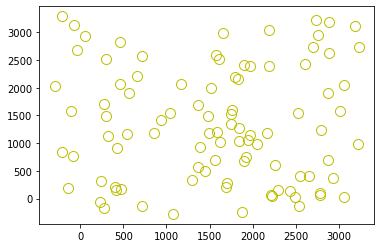

In [9]:
#show results of fits with perfect WCS
print (results.scatterOnSky.asArcseconds())

plotAstrometry(
    results.matches,
    refCat=None,
    sourceCat=None,
    refMarker="x",
    refColor="r",
    sourceMarker="+",
    sourceColor="g",
    matchColor="y"
)

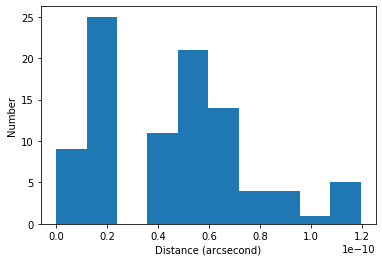

In [10]:
plotDistances(results.matches)

0.0014469828909139514


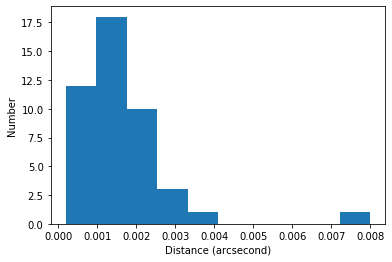

In [11]:
sourceSchema = afwTable.SourceTable.makeMinimalSchema()
measBase.SingleFrameMeasurementTask(schema=sourceSchema)

config = AstrometryTask.ConfigClass()
config.wcsFitter.order = 2
config.wcsFitter.numRejIter = 0
solver = AstrometryTask(config=config, refObjLoader=refObjLoader, schema=sourceSchema)
results = solver.run(
    sourceCat=distortedSourceCat,
    exposure=exposure,
)
print (results.scatterOnSky.asArcseconds())
plotDistances(results.matches)